In [ ]:
import os
os.chdir('/content/drive/MyDrive/DA_ChuyenNganhKHDL')

In [ ]:
import os, csv, sys
import unicodedata as ud

from text_utils import remove_punc, token_sylabling, is_word

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

import itertools
import pandas as pd
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import joblib
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

#Xử lý dữ liệu

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DA_ChuyenNganhKHDL/Data/preproc_vn_news_226_tdlfr.csv')
data.head()

,text,label
0,Thủ_tướng Abe cúi đầu xin_lỗi hành_động phi th...,1
1,Thủ_tướng Nhật cúi đầu xin_lỗi tinh_thần phi t...,1
2,Choáng ! Cơ_trưởng đeo khăn_quàng quẩy banh nó...,1
3,Chưa_bao_giờ nhạc Kpop dễ hát đến_thế ! ! ! Gi...,1
4,"Đại_học Hutech áp_dụng cải_cách "" Tiếq Việt "" ...",1


In [ ]:
data.shape

(226, 2)

Chuẩn bị dữ liệu: Loại bỏ dấu câu, số, ngày tháng, url... -> Chuyển thành chữ viết thường

In [ ]:
def data_preparing(text):
    text_list = text.lower().split()
    new_text = ''
    for word in text_list:
        if(is_word(word)):
            new_text = ' '.join([new_text, word])
    return new_text

Chuyển đổi dữ liệu

In [ ]:
X_news_data = data['text'].apply(data_preparing)
y_news_data = data['label']

In [ ]:
X_news_data.head(1)

,text
0,thủ_tướng abe cúi đầu xin_lỗi hành_động phi thể_thao tuyển nhật theo sankei sports sáng nay thủ_tướng nhật_bản shinzo abe công_khai gửi_lời xin_lỗi tới nhật hoàng toàn_bộ người dân tinh_thần thi_đấu phi thể_thao đội_tuyển nhật world_cup tối lượt trận cuối vòng bảng world_cup nhật_bản chỉ_số phụ senegal đội loại thua nhưng nhật_bản vòng nhờ chỉ_số fair play nhận ít thẻ phạt hơn thủ_tướng nhật_bản shinzo abe cúi đầu xin_lỗi với tinh_thần võ_sĩ_đạo samurai đội_tuyển nhật_bản hành_động thiếu tinh_thần thượng_võ trong thi_đấu world_cup để_lại chỉ_trích bất_bình toàn_dân làm mất hình_ảnh kiên_cường người dân nhật_bản đấu_trường quốc_tế là người đứng_đầu tôi xin thành_thật nhận trách_nhiệm gửi_lời xin_lỗi sâu_sắc tới nhân_dân ông abe cúi đầu nhận trách_nhiệm về mình người nhật_bản nổi_tiếng về tinh_thần trách_nhiệm chất võ_sĩ_đạo đó lý_do đội_tuyển áo_xanh mệnh_danh samurai xanh tuy_nhiên nhật_bản sau_đó nhận chỉ_trích dữ_dội người hâm_mộ bóng_đá lối chơi bóng tiêu_cực cố_tình câu giờ để_dành tấm vé đi tiếp cụ_thể phút cuối trận cuối vòng bảng gặp ba_lan biết ở trận giờ colombia thắng senegal tỷ_số dù dẫn tỉ_số tương_tự cầu_thủ nhật_bản không_hề muốn gỡ hòa các cầu_thủ nhật vui_vẻ trận thua ba_lan vé vòng đội tại world_cup fifa tính điểm fair play quy_định thẻ_vàng điểm thẻ_vàng thành thẻ_đỏ điểm thẻ_đỏ trực_tiếp điểm nhật thẻ_vàng còn senegal đến chính sợ lãnh thêm thẻ_vàng nhật giết chết trận đấu trong phút cuối họ liên_tục chuyền_bóng qua_lại ở phần sân_nhà thậm_chí trong_khoảng phút cuối cầu_thủ nhật_bản còn đưa bóng sang phần sân đối_phương bất_chấp la_ó huýt_sáo cđv sân điều khiến thầy_trò hlv akira nishino dư_luận chỉ_trích với kết_quả nhật_bản colombia hai đội đi tiếp bảng ở vòng_loại trực_tiếp nhật_bản đối_đầu đối_thủ cực_mạnh đt bỉ trong_khi đội đi tiếp nhật colombia gặp đt


In [ ]:
X_news_train, X_news_test, y_news_train, y_news_test = train_test_split(X_news_data, y_news_data, test_size = 0.2)

In [ ]:
print(X_news_train.shape)
print(y_news_train.shape)
print(X_news_test.shape)
print(y_news_test.shape)

(180,)
(180,)
(46,)
(46,)


In [ ]:
tfidfVectorizer = TfidfVectorizer()

X_data_train_tfidf = tfidfVectorizer.fit_transform(X_news_train)
print(X_data_train_tfidf.shape)
X_data_test_tfidf = tfidfVectorizer.transform(X_news_test)
print(X_data_test_tfidf.shape)


(180, 8235)
(46, 8235)


# 2. Naive Bayes classification

In [ ]:
MultiNB_clf = Pipeline([
    ('tfidfvect', TfidfVectorizer()),
    ('nbclf', MultinomialNB())
])
MultiNB_clf.fit(X_news_train, y_news_train)

Pipeline(steps=[('tfidfvect', TfidfVectorizer()), ('nbclf', MultinomialNB())])

In [ ]:
data_predict = MultiNB_clf.predict(X_news_test)
data_predict_log_proba = MultiNB_clf.predict_log_proba(X_news_test)
data_predict_proba = MultiNB_clf.predict_proba(X_news_test)
print(data_predict)

[0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 1 0 1 0 0 1 0]


In [ ]:
accuracy = MultiNB_clf.score(X_news_train, y_news_train)
print('Train',accuracy)
accuracy = MultiNB_clf.score(X_news_test, y_news_test)
print('Test',accuracy)

Train 0.9722222222222222
Test 0.8913043478260869


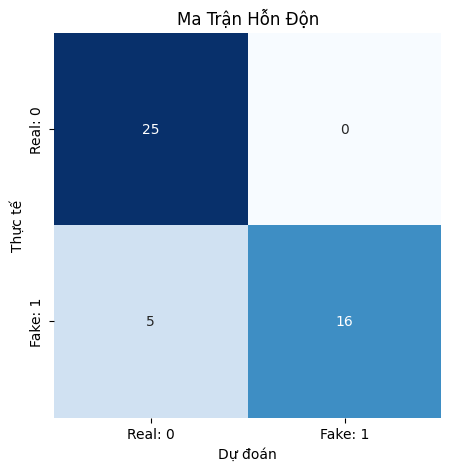

In [ ]:
import seaborn as sns

cnf_matrix = confusion_matrix(y_news_test, data_predict)
np.set_printoptions(precision=2)

plt.figure(figsize=(5, 5))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real: 0', 'Fake: 1'], yticklabels=['Real: 0', 'Fake: 1'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma Trận Hỗn Độn')
plt.show()

In [ ]:
print(classification_report(y_news_test, data_predict, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.83      1.00      0.91        25
        Fake       1.00      0.76      0.86        21

    accuracy                           0.89        46
   macro avg       0.92      0.88      0.89        46
weighted avg       0.91      0.89      0.89        46



In [ ]:
os.mkdir('/content/drive/MyDrive/DA_ChuyenNganhKHDL/Model')

In [ ]:
joblib.dump(MultiNB_clf, '/content/drive/MyDrive/DA_ChuyenNganhKHDL/Model/MultiNB_clf.sav')

['/content/drive/MyDrive/DA_ChuyenNganhKHDL/Model/MultiNB_clf.sav']

##Điều chỉnh tham số

In [ ]:
MultiNB_clf_tt = Pipeline([
    ('tfidfvect', TfidfVectorizer()),
    ('nbclf', MultinomialNB())
])
#định nghĩa các tham số
parameters = {
    'tfidfvect__ngram_range': [(1, 1), (1, 2)],
    'tfidfvect__use_idf': (True, False),
    'nbclf__alpha': (1e-2, 1e-3),
}

gs_clf = GridSearchCV(MultiNB_clf_tt, parameters, cv=5, n_jobs=-1)

gs_clf = gs_clf.fit(X_news_train, y_news_train)

print(gs_clf.best_score_)

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.9222222222222222
nbclf__alpha: 0.01
tfidfvect__ngram_range: (1, 2)
tfidfvect__use_idf: True


In [ ]:
MultiNB_text_clf_tt = Pipeline([
    ('tfidfvect', TfidfVectorizer(ngram_range = (1, 2))),
    ('nbclf', MultinomialNB(alpha = 0.01))
])
MultiNB_text_clf_tt.fit(X_news_train, y_news_train)


Pipeline(steps=[('tfidfvect', TfidfVectorizer(ngram_range=(1, 2))),
                ('nbclf', MultinomialNB(alpha=0.01))])

In [ ]:
data1_predict = MultiNB_text_clf_tt.predict(X_news_test)

In [ ]:
accuracy = MultiNB_text_clf_tt.score(X_news_train, y_news_train)
print('Train',accuracy)
accuracy = MultiNB_text_clf_tt.score(X_news_test, y_news_test)
print('Test',accuracy)

Train 1.0
Test 0.9130434782608695


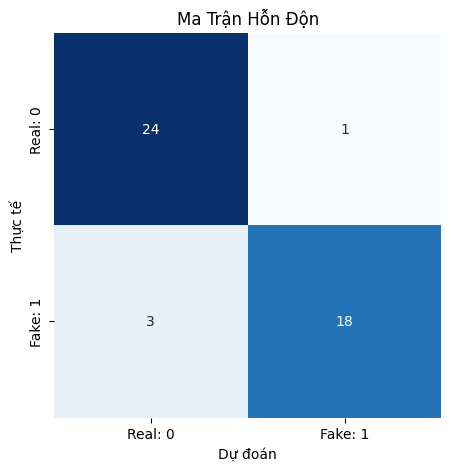

In [ ]:
import seaborn as sns

cnf_matrix = confusion_matrix(y_news_test, data1_predict)
np.set_printoptions(precision=2)

plt.figure(figsize=(5, 5))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real: 0', 'Fake: 1'], yticklabels=['Real: 0', 'Fake: 1'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma Trận Hỗn Độn')
plt.show()

In [ ]:
print(classification_report(y_news_test, data1_predict, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.89      0.96      0.92        25
        Fake       0.95      0.86      0.90        21

    accuracy                           0.91        46
   macro avg       0.92      0.91      0.91        46
weighted avg       0.92      0.91      0.91        46



In [ ]:
joblib.dump(MultiNB_text_clf_tt, '/content/drive/MyDrive/DA_ChuyenNganhKHDL/Model/MultiNB_text_clf_tt91.sav')

['/content/drive/MyDrive/DA_ChuyenNganhKHDL/Model/MultiNB_text_clf_tt91.sav']

# 3. SVM classification

In [ ]:
svm = Pipeline([
    ('tfidfvect', TfidfVectorizer(ngram_range=(1, 2))),
    ('svm', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None))
])
svm.fit(X_news_train, y_news_train)

Pipeline(steps=[('tfidfvect', TfidfVectorizer(ngram_range=(1, 2))),
                ('svm',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
svm_predict = svm.predict(X_news_test)

In [ ]:
accuracy = svm.score(X_news_train, y_news_train)
print('Train',accuracy)
accuracy = svm.score(X_news_test, y_news_test)
print('Test',accuracy)

Train 1.0
Test 0.9347826086956522


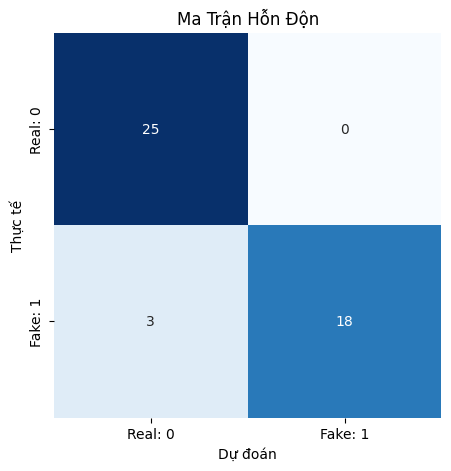

In [ ]:
cnf_matrix = confusion_matrix(y_news_test, svm_predict)
np.set_printoptions(precision=2)

plt.figure(figsize=(5, 5))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real: 0', 'Fake: 1'], yticklabels=['Real: 0', 'Fake: 1'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma Trận Hỗn Độn')
plt.show()

In [ ]:
print(classification_report(y_true=y_news_test, y_pred=svm_predict, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.89      1.00      0.94        25
        Fake       1.00      0.86      0.92        21

    accuracy                           0.93        46
   macro avg       0.95      0.93      0.93        46
weighted avg       0.94      0.93      0.93        46



In [ ]:
joblib.dump(svm, '/content/drive/MyDrive/DA_ChuyenNganhKHDL/Model/svm93.sav')

['/content/drive/MyDrive/DA_ChuyenNganhKHDL/Model/svm93.sav']

##Tinh chỉnh mô hình

In [ ]:
svm_tt = Pipeline([
    ('tfidfvect', TfidfVectorizer()),
    ('svm', SGDClassifier(loss='hinge',
                          random_state=42,
                          tol=None))
])

param_grid = {
    'tfidfvect__ngram_range': [(1, 1), (1, 2)],
    'svm__alpha': [1e-4, 1e-3, 1e-2],
    'svm__max_iter': [5, 10, 50],
    'svm__penalty': ['l2', 'elasticnet']
}

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(svm_tt, param_grid, cv=5, n_jobs=-1, verbose=1)

# Huấn luyện mô hình
grid_search.fit(X_news_train, y_news_train)

# In kết quả tốt nhất
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'svm__alpha': 0.0001, 'svm__max_iter': 10, 'svm__penalty': 'elasticnet', 'tfidfvect__ngram_range': (1, 2)}
Best score:  0.9166666666666666


In [ ]:
svm_ttt = Pipeline([
    ('tfidfvect', TfidfVectorizer(ngram_range=(1, 2))),
    ('svm', SGDClassifier(loss='hinge', penalty='elasticnet',
                           alpha=1e-4, random_state=42,
                           max_iter=10, tol=None))
])
svm_ttt.fit(X_news_train, y_news_train)

Pipeline(steps=[('tfidfvect', TfidfVectorizer(ngram_range=(1, 2))),
                ('svm',
                 SGDClassifier(max_iter=10, penalty='elasticnet',
                               random_state=42, tol=None))])

In [ ]:
svm_predict_tt = svm_ttt.predict(X_news_test)

In [ ]:
accuracy = svm_ttt.score(X_news_train, y_news_train)
print('Train',accuracy)
accuracy = svm_ttt.score(X_news_test, y_news_test)
print('Test',accuracy)

Train 1.0
Test 0.8913043478260869


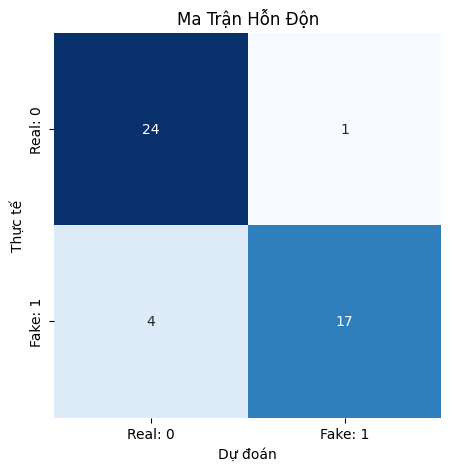

In [ ]:
cnf_matrix = confusion_matrix(y_news_test, svm_predict_tt)
np.set_printoptions(precision=2)

plt.figure(figsize=(5, 5))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real: 0', 'Fake: 1'], yticklabels=['Real: 0', 'Fake: 1'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma Trận Hỗn Độn')
plt.show()

In [ ]:
print(classification_report(y_true=y_news_test, y_pred=svm_predict_tt, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.86      0.96      0.91        25
        Fake       0.94      0.81      0.87        21

    accuracy                           0.89        46
   macro avg       0.90      0.88      0.89        46
weighted avg       0.90      0.89      0.89        46



In [ ]:
joblib.dump(svm_ttt, '/content/drive/MyDrive/DA_ChuyenNganhKHDL/Model/svm_ttt89.sav')

['/content/drive/MyDrive/DA_ChuyenNganhKHDL/Model/svm_ttt89.sav']

#=============================================END=============================================